In [168]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

In [169]:
df = pd.read_csv('../tm_tweets/dataset_with_topic_labels.csv')
df.head()

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count,cleaned_text,Toxicity,Fact assessment,Trivia question,Offensive Assessment,topic_label
0,2020-08-13T16:55:49Z,California,LIVE: Trump holds press conference https://t.c...,Twitter Web App,71,en,0,0,False,3281,4938,4,39349,23299,live : trump hold press conference via,1,no verdict,NaN,NaN,-1
1,2020-08-30T00:03:31Z,Tennessee,Trump’s claim the ‘silent majority’ will save ...,Twitter Web App,205,en,9,2,False,2866,3000,2,23786,30906,trump 's claim the ‘ silent majority ' will sa...,8,'no verdict',NaN,NaN,-1
2,2020-10-26T23:16:05Z,New York,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,Twitter Web App,267,en,7,4,False,32221,26550,52,304911,146137,#newhampshire #voteblue #votebluetosaveamerica...,2,'true',NaN,NaN,1
3,2020-08-24T09:54:59Z,Florida,"@davidsirota I'm so confused, when is the medi...",Twitter for Android,262,en,2,0,False,457,375,5,16851,7429,"i 'm so confused , when is the medium going t...",7,'no verdict',NaN,NaN,-1
4,2021-02-04T11:31:07Z,Washington,@Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...,Twitter for Android,88,en,0,0,False,43,177,0,2618,1517,yep ! he ha balls ! ! now with our whimp in ...,8,'false',NaN,NaN,16


In [170]:
df['Fact assessment'].value_counts()

Fact assessment
'no verdict'          650
'true'                320
False                 320
No verdict            228
'false'               179
True                   96
no verdict             52
true                   46
false                  17
'False'                 6
'No verdict'            3
'True'                  1
'without evidence'      1
Name: count, dtype: int64

In [171]:
df['Toxicity'].value_counts()

Toxicity
8     612
7     452
3     333
2     250
1     176
9      69
10     19
6       5
4       3
Name: count, dtype: int64

In [172]:
df['fake_binary'] = ((df['Fact assessment'] == 'false') | 
                    (df['Fact assessment'] == 'False') | 
                    (df['Fact assessment'] == "'False'") | 
                    (df['Fact assessment'] == "'false'")).rename('fake_binary').astype(int)
df['fake_binary'].value_counts()

fake_binary
0    1397
1     522
Name: count, dtype: int64

In [173]:
df['source'].unique()

array(['Twitter Web App', 'Twitter for Android', 'Twitter for iPhone',
       'SocialNewsDesk', 'Twitter for iPad', 'TweetDeck', 'dlvr.it',
       'TweetCaster for Android', 'IFTTT', 'BLOX CMS', 'SocialFlow',
       'The Tweeted Times', 'WordPress.com', 'Buffer',
       'Cheap Bots, Done Quick!', 'ContentStudio.io',
       'SmartNews | スマートニュース', 'NauseousAmerica', 'ClientWhys Social',
       'Salesforce - Social Studio', 'Tweetbot for iΟS', 'PromoRepublic',
       'Twitterrific for Mac', nan, 'Twibble.io', 'OneCMS Social Connect',
       'chirr.app', 'Yelm Community Blog'], dtype=object)

In [174]:
df['topic_label'].value_counts()

topic_label
-1     711
 0     361
 1     204
 2      57
 3      54
 4      43
 5      41
 6      33
 7      33
 8      32
 9      31
 10     30
 11     24
 12     23
 13     21
 14     19
 15     18
 16     18
 17     17
 18     17
 19     15
 20     15
 21     14
 22     14
 23     14
 24     14
 25     13
 26     11
 27     11
 28     11
Name: count, dtype: int64

In [175]:
apple_binary = df['source'].apply(lambda x: 1 if x in ['Tweetbot for Mac',
                                                            'Tweetbot for iΟS',
                                                            'Twitter for Mac',
                                                            'Twitter for iPad',
                                                            'Twitter for iPhone',
                                                            'Twitterrific for iOS', 'Twitterrific for Mac'] else 0).rename('apple_binary').astype(int)
apple_binary.value_counts()

apple_binary
0    1095
1     824
Name: count, dtype: int64

In [176]:
elections = pd.read_csv('../../data/1976-2020-president.csv')
elections = elections[elections['year'] == 2020]
elections = elections[elections['party_detailed'].isin(['DEMOCRAT', 'REPUBLICAN'])]	
elections['state'] = elections['state'].str.title()
elections['party_detailed'] = elections['party_detailed'].str.title()

winner_df = elections.loc[elections.groupby('state')['candidatevotes'].idxmax()]

# Select only the state and the winning party columns
winner_df = winner_df[['state', 'party_detailed']]



In [177]:
winning_party = df.merge(winner_df, left_on='state_likely_tweeted_from', right_on='state', how='left')
winning_party = winning_party['party_detailed']
winning_party_republican = winning_party.replace({'Republican': 1, 'Democrat': 0})

C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\1852377355.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  winning_party_republican = winning_party.replace({'Republican': 1, 'Democrat': 0})


In [178]:
state_dummies = pd.get_dummies(df, columns=['state_likely_tweeted_from'],drop_first=True)
# Filtering to get just the state dummy columns
state_columns = [col for col in state_dummies.columns if col.startswith('state_likely_tweeted_from_')]
states_matrix = state_dummies[state_columns].astype(int)
states_matrix

,state_likely_tweeted_from_Alaska,state_likely_tweeted_from_Arizona,state_likely_tweeted_from_Arkansas,state_likely_tweeted_from_California,state_likely_tweeted_from_Colorado,state_likely_tweeted_from_Florida,state_likely_tweeted_from_Georgia,state_likely_tweeted_from_Hawaii,state_likely_tweeted_from_Idaho,state_likely_tweeted_from_Illinois,...,state_likely_tweeted_from_South Dakota,state_likely_tweeted_from_Tennessee,state_likely_tweeted_from_Texas,state_likely_tweeted_from_Utah,state_likely_tweeted_from_Vermont,state_likely_tweeted_from_Virginia,state_likely_tweeted_from_Washington,state_likely_tweeted_from_West Virginia,state_likely_tweeted_from_Wisconsin,state_likely_tweeted_from_Wyoming
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
topic_dummies = pd.get_dummies(df, columns=['topic_label'],drop_first=True)
# Filtering to get just the state dummy columns
topic_columns = [col for col in topic_dummies.columns if col.startswith('topic_label')]
topic_matrix = topic_dummies[topic_columns].astype(int)
topic_matrix

,topic_label_0,topic_label_1,topic_label_2,topic_label_3,topic_label_4,topic_label_5,topic_label_6,topic_label_7,topic_label_8,topic_label_9,...,topic_label_19,topic_label_20,topic_label_21,topic_label_22,topic_label_23,topic_label_24,topic_label_25,topic_label_26,topic_label_27,topic_label_28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1914,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [180]:
# avoid division by 0 later on
df['followers_count'] += 1

In [181]:
df['likes_per_1000followers'] = ((df['favorite_count'] / df['followers_count']) * 1000).astype(int)
df['likes_per_1000followers'].describe()

count    1919.000000
mean       16.131318
std       154.559762
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      3500.000000
Name: likes_per_1000followers, dtype: float64

In [182]:
df.columns

Index(['created_at_fuzzy', 'state_likely_tweeted_from', 'text', 'source',
       'display_text_width', 'lang', 'favorite_count', 'retweet_count',
       'is_quote', 'followers_count', 'friends_count', 'listed_count',
       'statuses_count', 'favourites_count', 'cleaned_text', 'Toxicity',
       'Fact assessment', 'Trivia question', 'Offensive Assessment',
       'topic_label', 'fake_binary', 'likes_per_1000followers'],
      dtype='object')

In [183]:
df = df[['fake_binary', 'retweet_count', 'favorite_count', 
       'is_quote', 'friends_count', 'followers_count', 
       'statuses_count', 'likes_per_1000followers', 'Toxicity']].astype(int)
df

,fake_binary,retweet_count,favorite_count,is_quote,friends_count,followers_count,statuses_count,likes_per_1000followers,Toxicity
0,0,0,0,0,4938,3282,39349,0,1
1,0,2,9,0,3000,2867,23786,3,8
2,0,4,7,0,26550,32222,304911,0,2
3,0,0,2,0,375,458,16851,4,7
4,1,0,0,0,177,44,2618,0,8
...,...,...,...,...,...,...,...,...,...
1914,0,0,2,0,1600,1547,5156,1,8
1915,0,0,0,0,50,29,758,0,8
1916,0,0,1,0,512,599,26537,1,3
1917,0,0,1,0,96,32,1041,31,2


In [184]:
YX = pd.concat([df, apple_binary, topic_matrix, winning_party_republican], axis=1) 
X = YX.drop(columns='fake_binary')
y = YX[['fake_binary']]

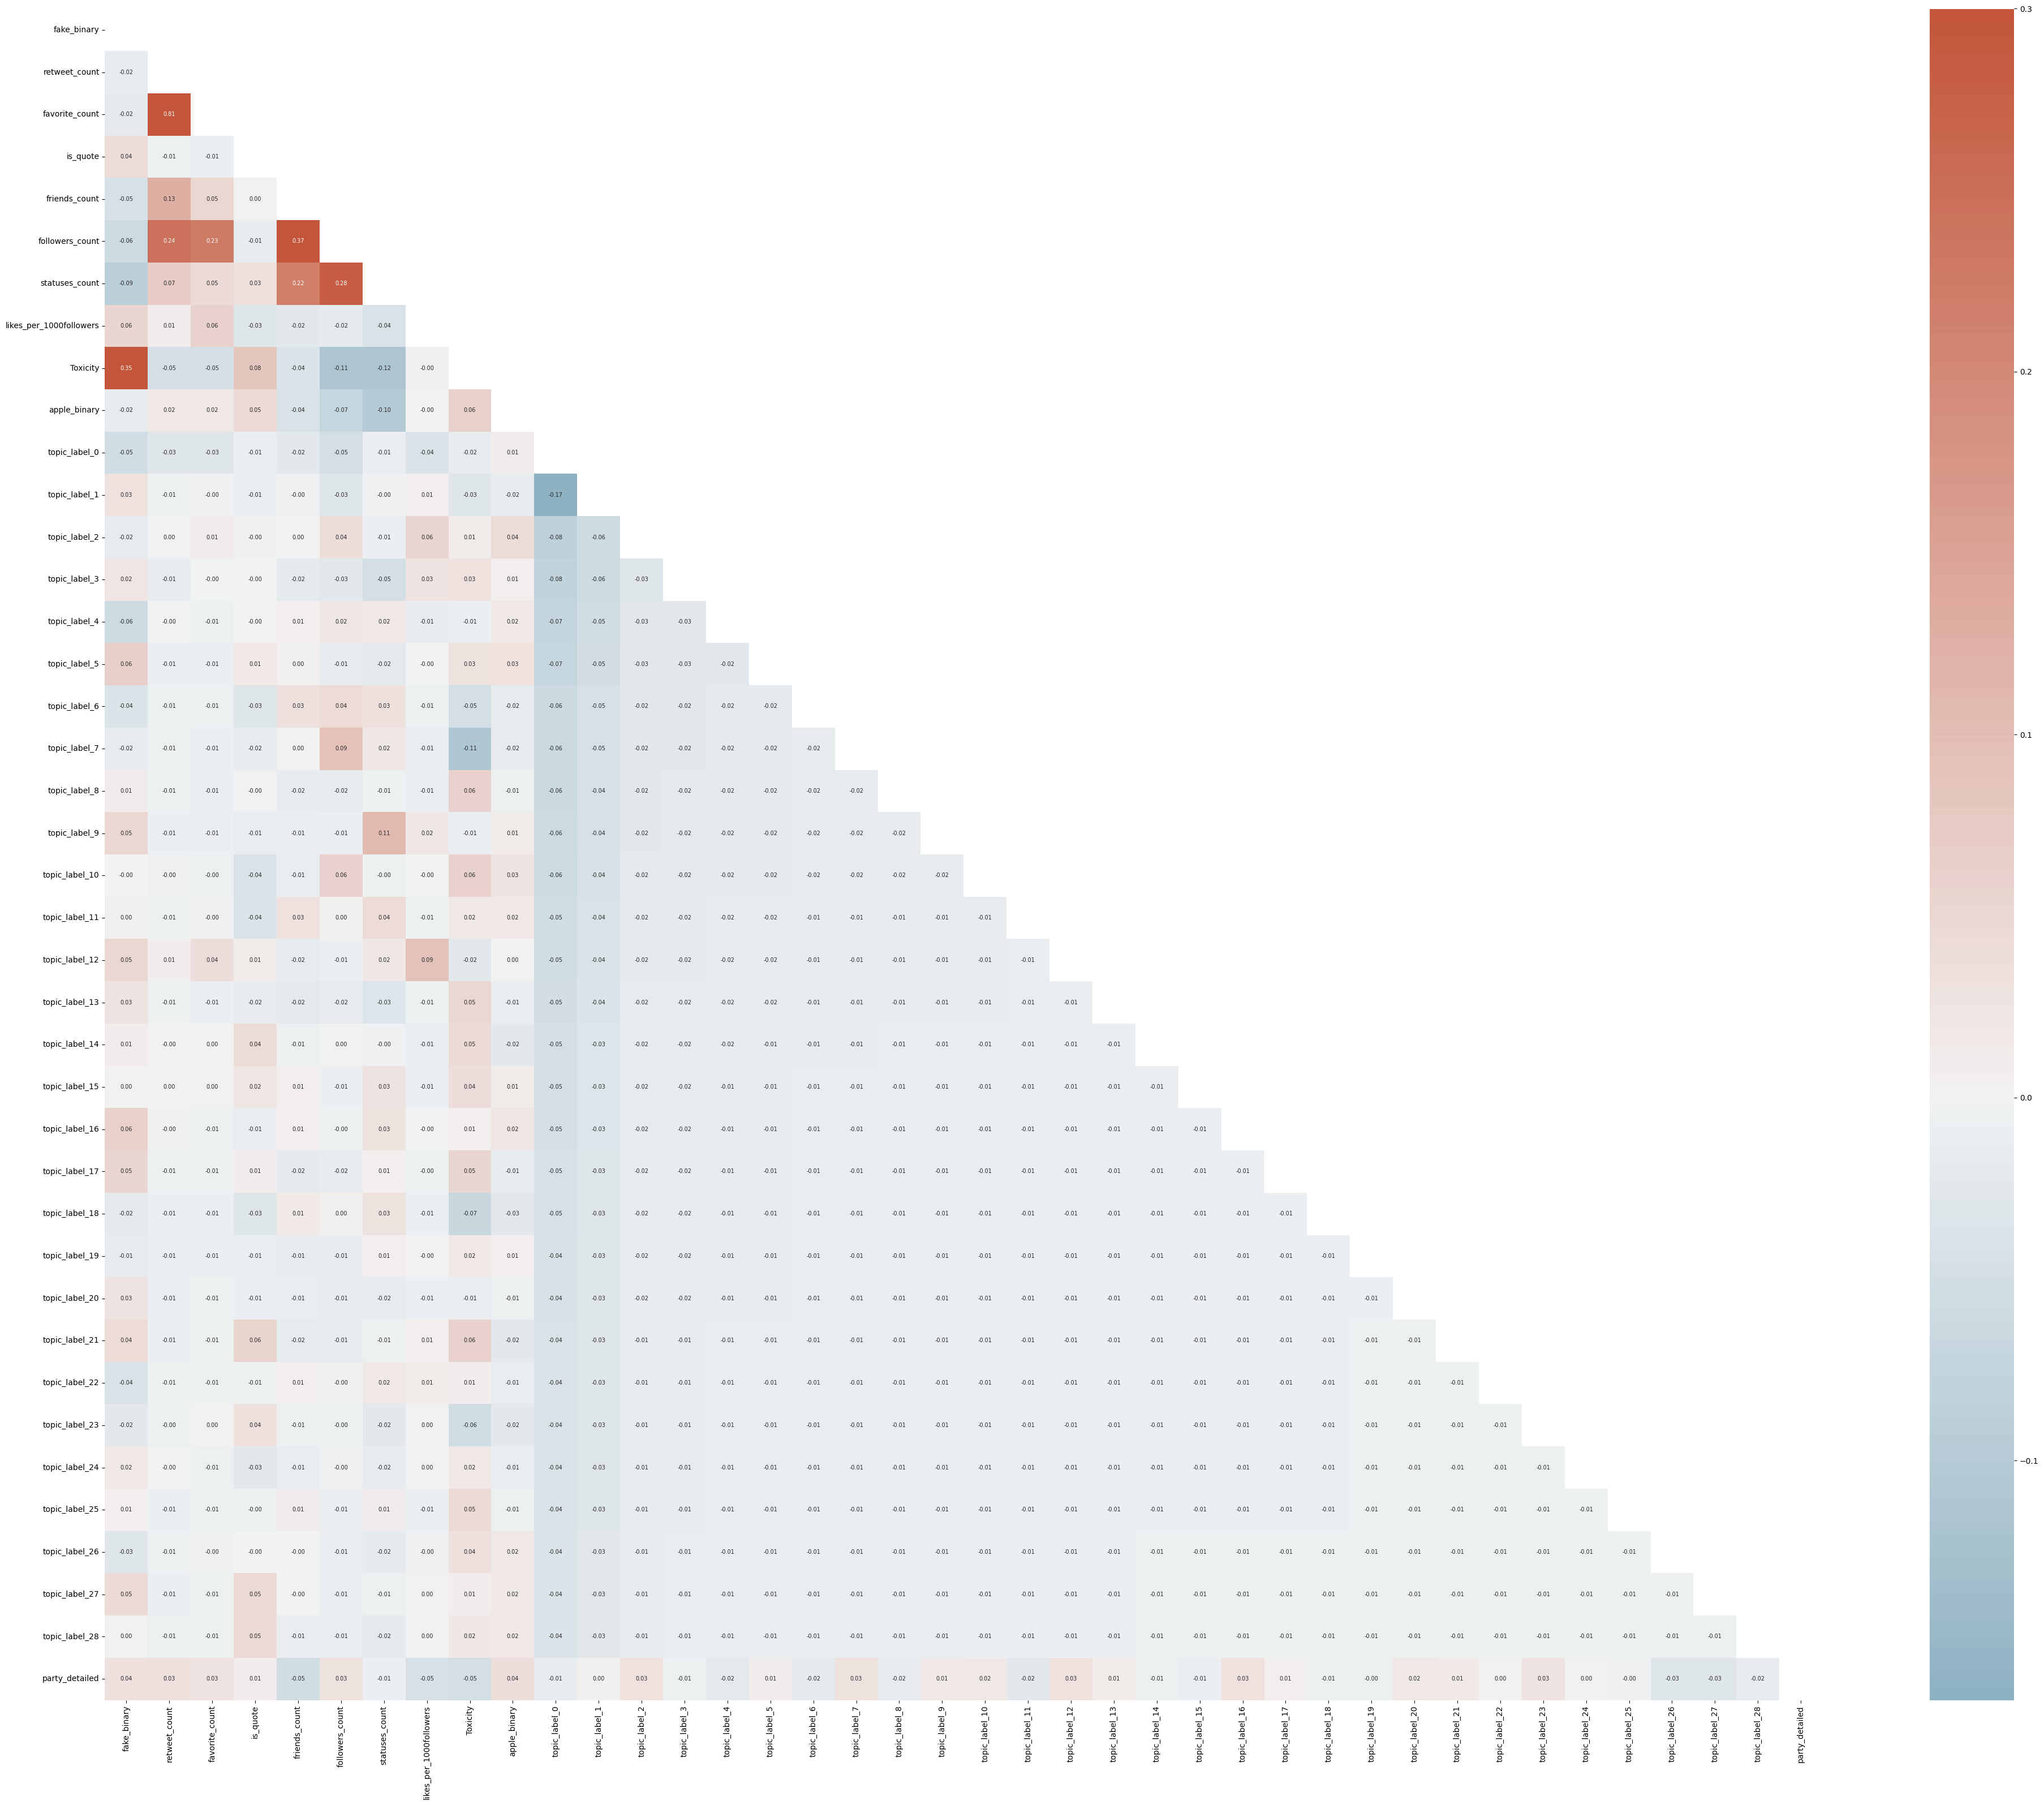

In [185]:
# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(40, 32))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

In [186]:
X = X.drop(columns=['retweet_count', 'friends_count'])

In [187]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Specify the columns to scale and the columns to leave unchanged
columns_to_scale = ['favorite_count', 'followers_count', 'statuses_count', 'likes_per_1000followers', 'Toxicity']
columns_to_leave_unchanged = [col for col in YX.columns if col not in columns_to_scale]

# Define the ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ('scaling', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Leave other columns unchanged
)

# Apply the transformations
transformed_data = ct.fit_transform(X)

transformed_column_names = columns_to_scale + [col for col in X.columns if col not in columns_to_scale]

# Convert the transformed data back to a DataFrame
X_scaled = pd.DataFrame(transformed_data, columns=transformed_column_names)

# Add constant
X_scaled_const = sm.add_constant(X_scaled)

# Iterate over columns
for column in X_scaled_const.columns:
    # Check if the column is not in columns_to_scale
    if column not in columns_to_scale:
        # Convert the column to integers
        X_scaled_const[column] = X_scaled_const[column].astype(int)

# Split data into 75% training and 25% test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_const, y, test_size=0.25, random_state=42)

YX_train = pd.concat([y_train, X_train], axis=1)
YX_test = pd.concat([y_test, X_test], axis=1)

In [188]:
X_scaled_const.head()

,const,favorite_count,followers_count,statuses_count,likes_per_1000followers,Toxicity,is_quote,apple_binary,topic_label_0,topic_label_1,...,topic_label_20,topic_label_21,topic_label_22,topic_label_23,topic_label_24,topic_label_25,topic_label_26,topic_label_27,topic_label_28,party_detailed
0,1,-0.106198,-0.064228,0.077506,-0.104397,-1.627380,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.180522,-0.080449,-0.135826,-0.084982,0.894318,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0.116807,1.066891,3.717732,-0.104397,-1.267138,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,-0.042483,-0.174604,-0.230889,-0.078510,0.534075,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,-0.106198,-0.190786,-0.425989,-0.104397,0.894318,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': [col for col in X_scaled_const.columns if (col not in states_matrix.columns.to_list()) and (col not in ['likes_per_1000followers']) and (col not in topic_matrix.columns.to_list())],
    'c': [col for col in X_scaled_const.columns if (col not in states_matrix.columns.to_list()) and (col not in ['followers_count', 'favorite_count']) and (col not in topic_matrix.columns.to_list())],
    'd': [col for col in X_scaled_const.columns if (col not in topic_matrix.columns.to_list()) and (col not in ['likes_per_1000followers'])],
    'e': [col for col in X_scaled_const.columns if (col not in states_matrix.columns.to_list()) and (col not in ['likes_per_1000followers'])],
    'f': [col for col in X_scaled_const.columns if (col not in states_matrix.columns.to_list()) and (col not in ['followers_count', 'favorite_count'])],
    'g': [col for col in X_scaled_const.columns if (col not in topic_matrix.columns.to_list()) and (col not in ['followers_count', 'favorite_count'])],
    'h': X_scaled_const.drop(columns=['likes_per_1000followers']).columns.tolist(),
    'i': X_scaled_const.drop(columns=['followers_count', 'favorite_count']).columns.tolist()
}

In [190]:
predictors

{'a': ['const'],
 'b': ['const',
  'favorite_count',
  'followers_count',
  'statuses_count',
  'Toxicity',
  'is_quote',
  'apple_binary',
  'party_detailed'],
 'c': ['const',
  'statuses_count',
  'likes_per_1000followers',
  'Toxicity',
  'is_quote',
  'apple_binary',
  'party_detailed'],
 'd': ['const',
  'favorite_count',
  'followers_count',
  'statuses_count',
  'Toxicity',
  'is_quote',
  'apple_binary',
  'party_detailed'],
 'e': ['const',
  'favorite_count',
  'followers_count',
  'statuses_count',
  'Toxicity',
  'is_quote',
  'apple_binary',
  'topic_label_0',
  'topic_label_1',
  'topic_label_2',
  'topic_label_3',
  'topic_label_4',
  'topic_label_5',
  'topic_label_6',
  'topic_label_7',
  'topic_label_8',
  'topic_label_9',
  'topic_label_10',
  'topic_label_11',
  'topic_label_12',
  'topic_label_13',
  'topic_label_14',
  'topic_label_15',
  'topic_label_16',
  'topic_label_17',
  'topic_label_18',
  'topic_label_19',
  'topic_label_20',
  'topic_label_21',
  'topic_l

In [191]:
y = YX_train['fake_binary'].astype(int) # Target variable

# Define K
K = 5

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# Initialize a dictionary to store Brier scores
scores = {key: [] for key in predictors}

# Initialize dictionaries to store scores
brier_scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}  
balanced_acc_scores = {key: [] for key in predictors}
aic_scores = {key: [] for key in predictors}  # AIC scores

for key, cols in predictors.items():
    print(key, cols)
    for train_index, test_index in kf.split(YX_train):
        
        # Split into train and test according to the folds 
        X_train, X_test = YX_train.iloc[train_index][cols], YX_train.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit_regularized(method='l1', disp=0)  # disp=0 suppresses the output
        #model = sm.Logit(y_train, X_train).fit()       
        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # Calculate Brier score
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # Convert probabilities to binary predictions (assume simple >0.5 probability as threshold)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        # Calculate Accuracy Score
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc_scores[key].append(acc_score)
        
        # Calculate Balanced Accuracy Score
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc_scores[key].append(bal_acc_score)
        
        # Store AIC
        aic_scores[key].append(model.aic)
        
        #print(model.summary())
        
# Calculate and print the average scores
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier_scores[key])
    average_bal_acc_score = np.mean(balanced_acc_scores[key])
    average_acc_score = np.mean(acc_scores[key])
    average_aic_score = np.mean(aic_scores[key])  # Calculate average AIC
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average AIC': average_aic_score
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
results_df

a ['const']
b ['const', 'favorite_count', 'followers_count', 'statuses_count', 'Toxicity', 'is_quote', 'apple_binary', 'party_detailed']
c ['const', 'statuses_count', 'likes_per_1000followers', 'Toxicity', 'is_quote', 'apple_binary', 'party_detailed']
d ['const', 'favorite_count', 'followers_count', 'statuses_count', 'Toxicity', 'is_quote', 'apple_binary', 'party_detailed']
e ['const', 'favorite_count', 'followers_count', 'statuses_count', 'Toxicity', 'is_quote', 'apple_binary', 'topic_label_0', 'topic_label_1', 'topic_label_2', 'topic_label_3', 'topic_label_4', 'topic_label_5', 'topic_label_6', 'topic_label_7', 'topic_label_8', 'topic_label_9', 'topic_label_10', 'topic_label_11', 'topic_label_12', 'topic_label_13', 'topic_label_14', 'topic_label_15', 'topic_label_16', 'topic_label_17', 'topic_label_18', 'topic_label_19', 'topic_label_20', 'topic_label_21', 'topic_label_22', 'topic_label_23', 'topic_label_24', 'topic_label_25', 'topic_label_26', 'topic_label_27', 'topic_label_28', 'par

,Model,Average Brier Score,Average Accuracy,Average Balanced Accuracy,Average AIC
0,a,0.195762,0.733152,0.500000,1337.548316
1,b,0.174457,0.741485,0.531753,1191.896525
2,c,0.171525,0.744974,0.534876,1187.751332
3,d,0.173295,0.742867,0.533665,1192.553740
4,e,0.173112,0.744962,0.571395,1196.968357
5,f,0.170153,0.751902,0.581460,1194.447482
6,g,0.173220,0.740108,0.535454,1187.008456
7,h,0.174926,0.743566,0.571998,1195.675614
8,i,0.172820,0.744967,0.575443,1192.228455


In [192]:
# Now fit the model to the full validation set
import pickle
model = sm.Logit(YX_train['fake_binary'], YX_train[predictors['i']]).fit_regularized(method='l1')
#model = sm.Logit(YX_train['fake_binary'], YX_train[predictors['i']]).fit()
pickle.dump(model, open('regression_model_MM.sav', 'wb'))
YX_test.to_csv('test_dataset.csv')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4901914739043905
            Iterations: 197
            Function evaluations: 197
            Gradient evaluations: 197


In [193]:
# Get summary results 
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1439
Model:                          Logit   Df Residuals:                     1403
Method:                           MLE   Df Model:                           35
Date:                Thu, 30 May 2024   Pseudo R-squ.:                  0.1550
Time:                        11:30:11   Log-Likelihood:                -705.39
converged:                       True   LL-Null:                       -834.77
Covariance Type:            nonrobust   LLR p-value:                 6.054e-36
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.4230      0.148     -9.647      0.000      -1.712      -1.134
statuses_count             -0.2256      0.095     -2.377      0.017      -0.412      -0.040


In [194]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [195]:
simulated_betas

array([[-1.2770982 , -0.13717179,  0.07384139, ...,  1.93345574,
         0.18411889,  0.13861394],
       [-1.6147067 , -0.38059095, -0.03357444, ...,  3.28812735,
         0.70003188,  0.43152772],
       [-1.59404243, -0.33907388,  0.05371668, ...,  2.45251532,
        -0.19614533,  0.17872339],
       ...,
       [-1.41095803, -0.15775089,  0.04485845, ...,  3.67204826,
        -2.05941047, -0.0064728 ],
       [-1.3521819 , -0.16320524,  0.11246391, ...,  2.02612246,
        -1.45979775,  0.30701402],
       [-1.43077092, -0.31460716,  0.11786729, ...,  3.35571556,
         0.27150318,  0.36097601]])

In [196]:
# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_test.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_test[predictors['i']], beta_simulation)
    beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions[i] = probabilities

# Derive odds from log-odds coefficients 
simulated_beta_odds = np.exp(simulated_betas)


C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\1805197552.py:8: RuntimeWarning: overflow encountered in exp
  beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\1805197552.py:8: RuntimeWarning: overflow encountered in exp
  beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\1805197552.py:8: RuntimeWarning: overflow encountered in exp
  beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\1805197552.py:8: RuntimeWarning: overflow encountered in exp
  beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\1805197552.py:8: RuntimeWarning: overflow encountered in exp
  beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\180519

In [197]:
# Check for non-finite values
non_finite_mask = ~np.isfinite(simulated_beta_odds)
if non_finite_mask.any():
    print(f"Non-finite values found: {non_finite_mask.sum()}")
    simulated_beta_odds = simulated_beta_odds[np.all(np.isfinite(simulated_beta_odds), axis=1)]

Non-finite values found: 113


In [198]:
# Calculate statistics for each coefficient
medians = np.median(simulated_beta_odds, axis=0)
lower_quantiles = np.percentile(simulated_beta_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_beta_odds, 95, axis=0)
prob_positive = np.mean(simulated_beta_odds > 1, axis=0)

# Plot names 
col_names = predictors['i']

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_beta_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_beta_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()


C:\Users\jelle\AppData\Local\Temp\ipykernel_6624\3547671928.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()

KeyboardInterrupt



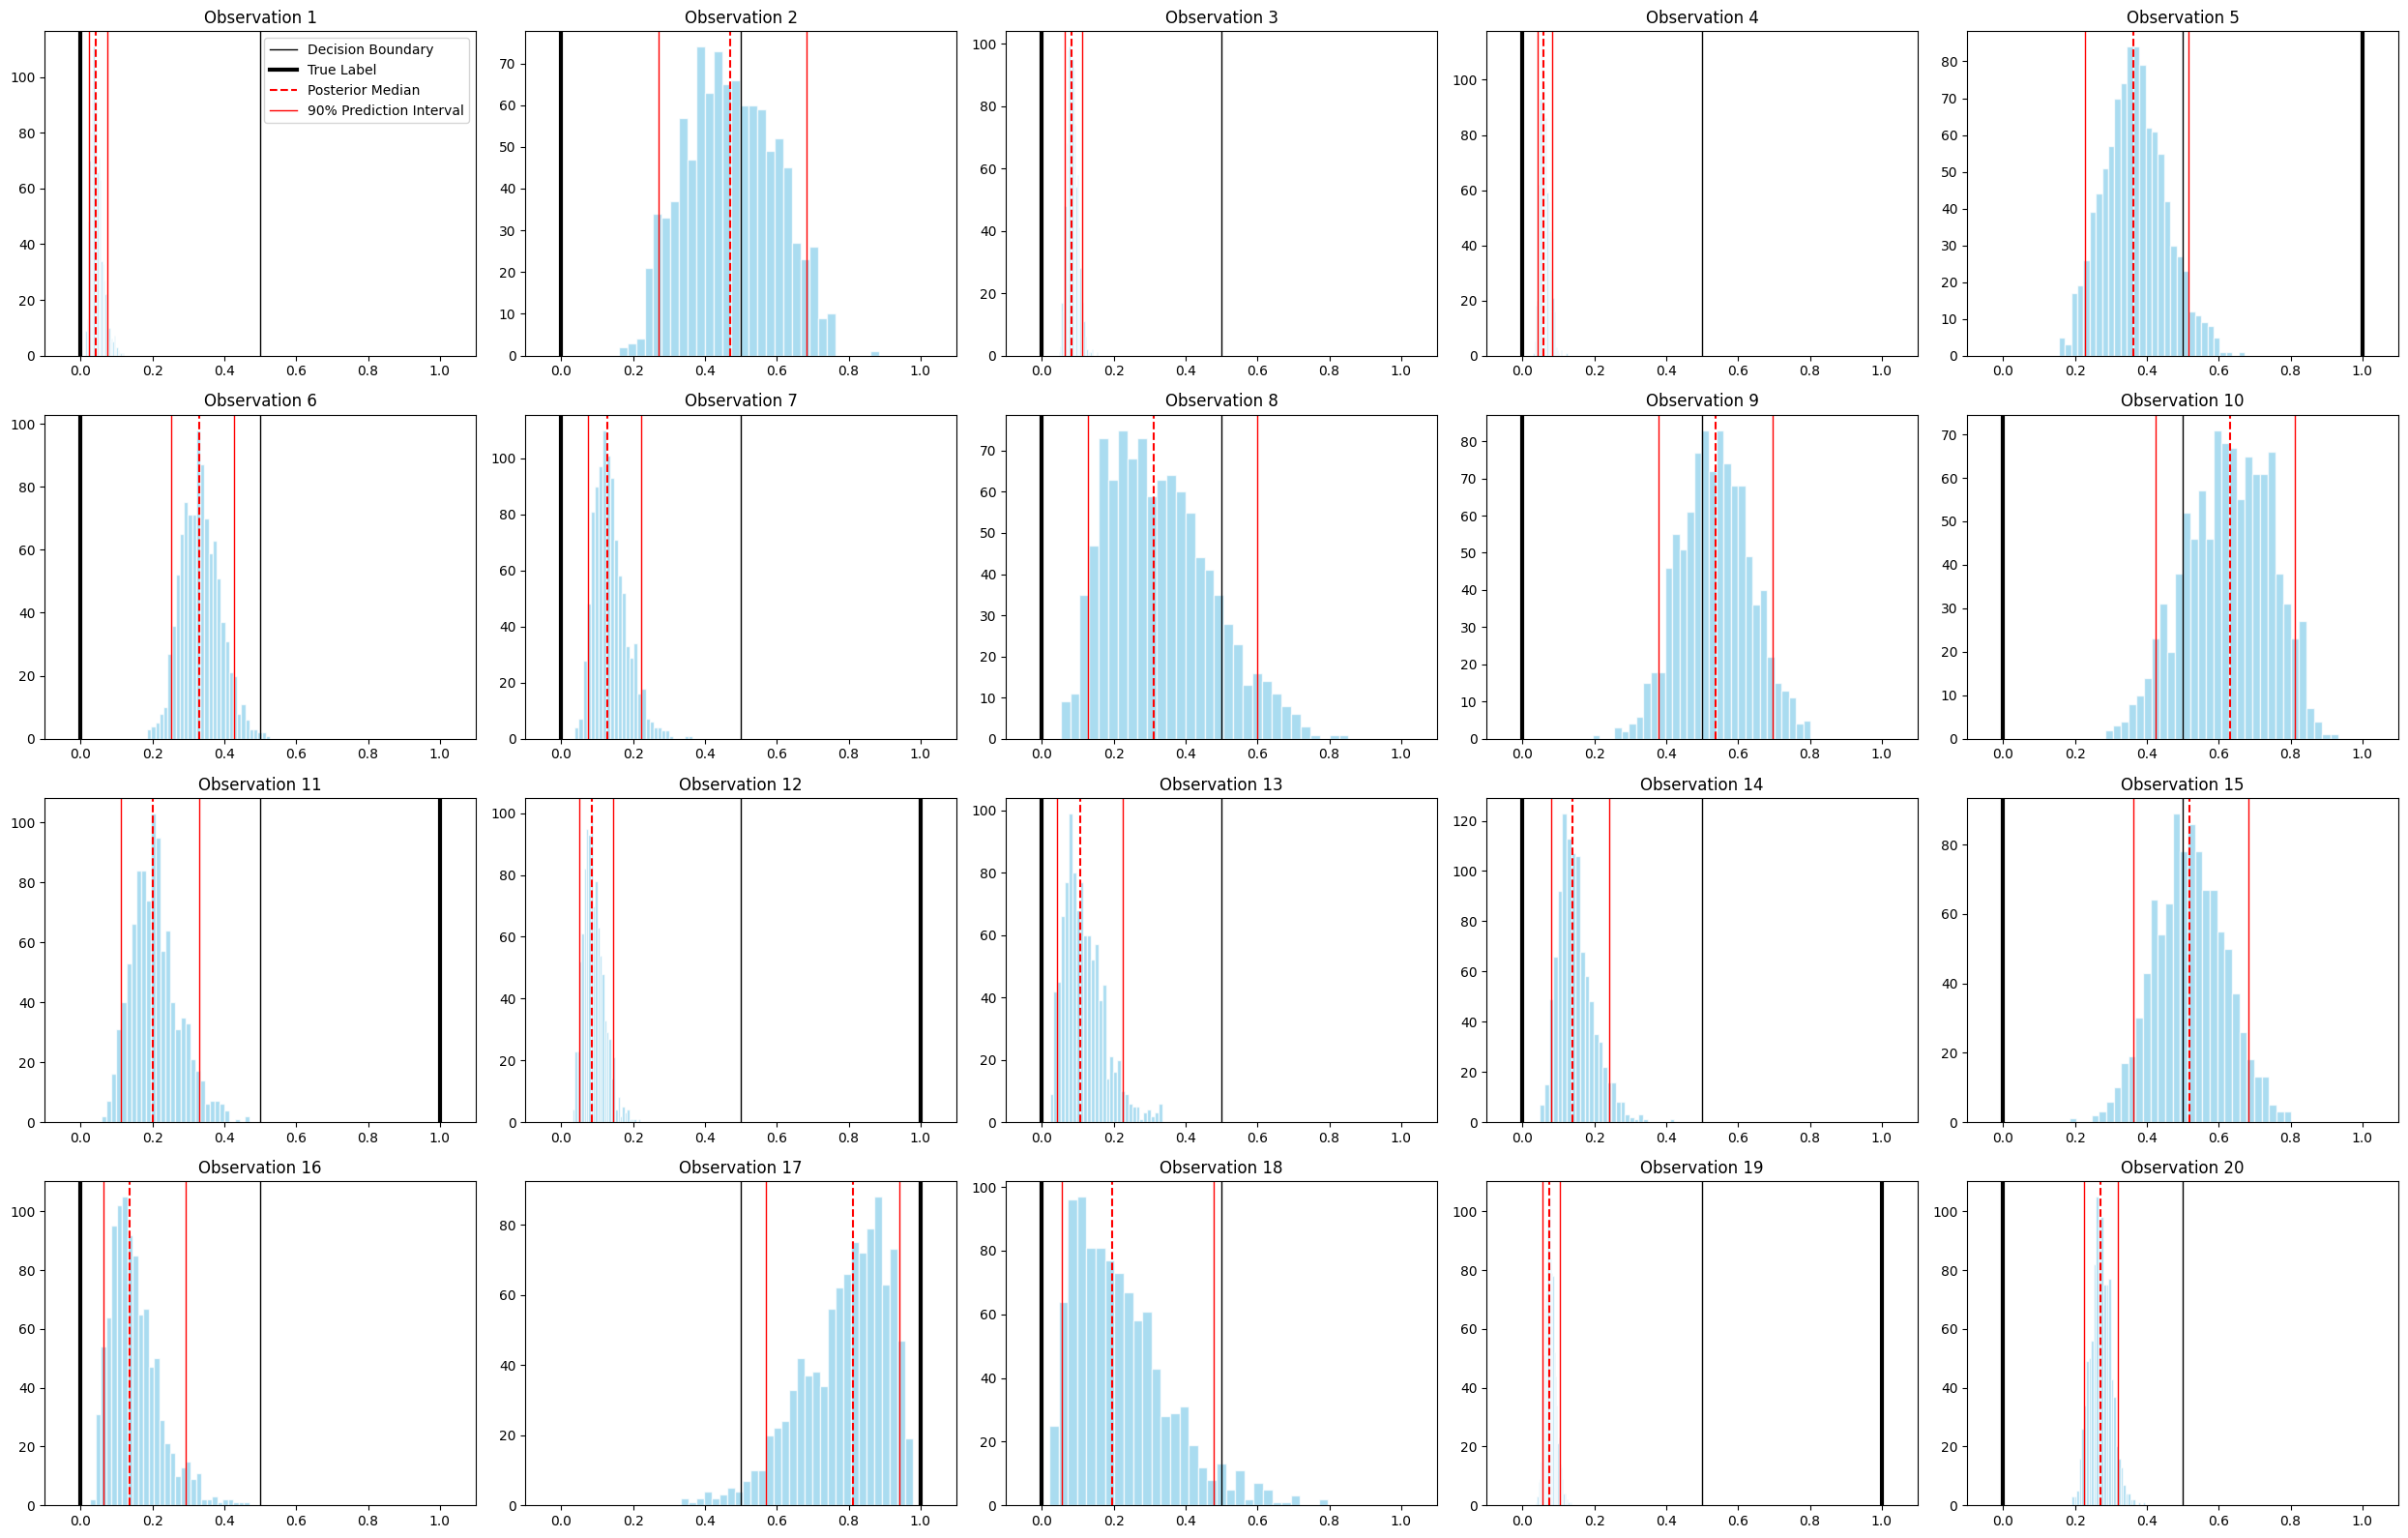

In [ ]:
true_labels = YX_test['fake_binary']

# Calculate posterior median and the 90% prediction interval
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

# Plotting with the adjustments for the 90% prediction interval to be shown with red lines
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for i in range(20):
    ax = axes[i // 5, i % 5]
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # Determine the position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    # Marking the 90% prediction interval with red lines instead of shading
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only to avoid repetition
        ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes = np.random.binomial(1, predictions)

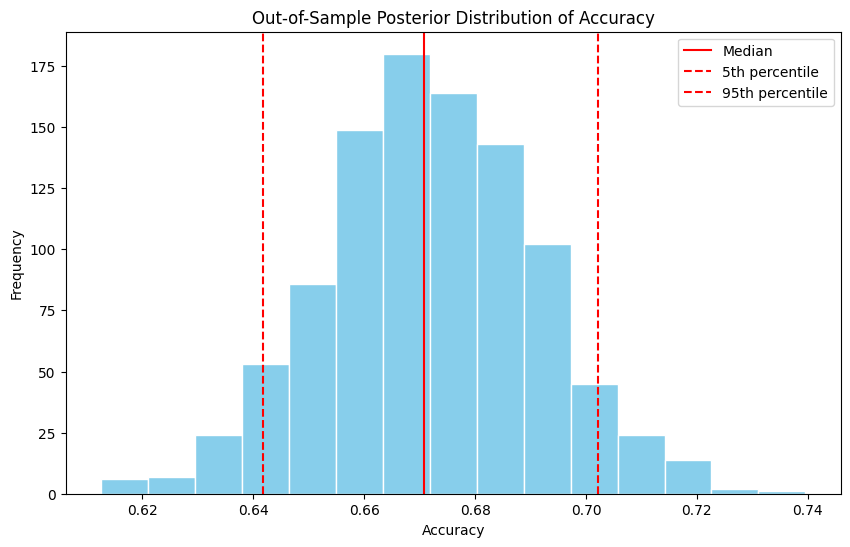

In [ ]:
# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=15, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()

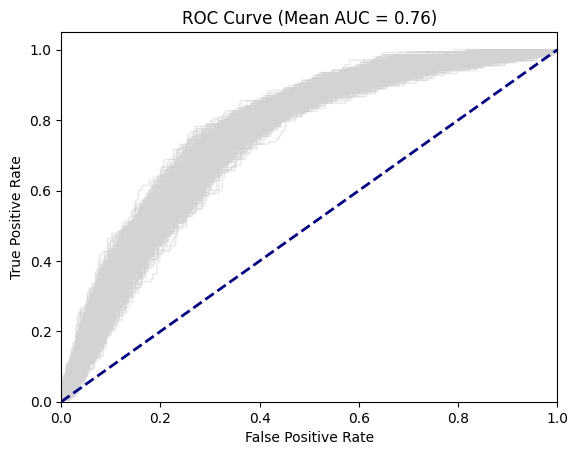

In [ ]:
# Initialize lists to store TPRs (True Positive Rate), FPRs (False Positive Rare), and AUCs (Area Under the Curve) for each simulation
tprs = []
fprs = []
aucs = []

# Calculate ROC curve and AUC for each simulation
for i in range(n_simulations):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[i])
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='lightgray', lw=1, alpha=0.5)  # Plot each ROC curve faintly

# Calculate the mean AUC
mean_auc = np.mean(aucs)

# Plotting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Mean AUC = {mean_auc:.2f})')
plt.show()

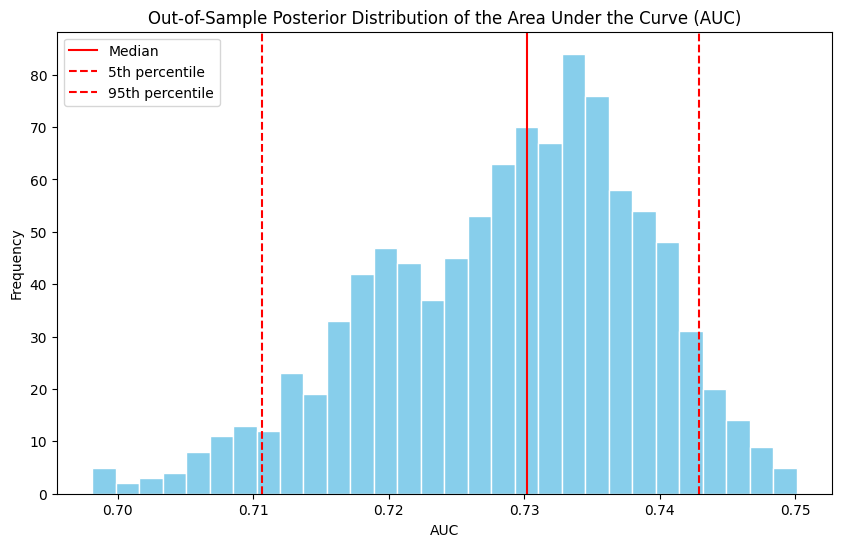

In [ ]:
# Plot the histogram of AUC
plt.figure(figsize=(10, 6))
plt.hist(aucs, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(aucs), color='red', label='Median')
plt.axvline(x=np.percentile(aucs, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(aucs, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of the Area Under the Curve (AUC)')
plt.legend()
plt.show()

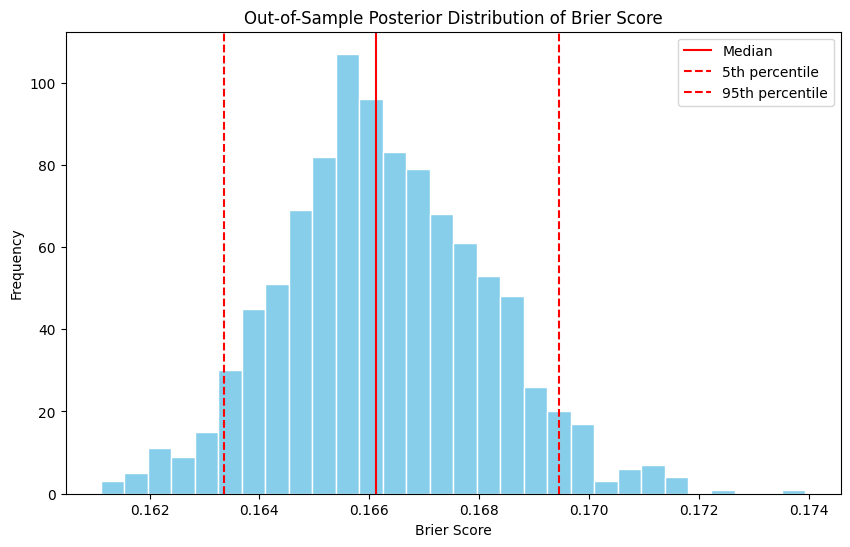

In [ ]:
# Calculate Brier score for each simulation
briers = [brier_score_loss(true_labels, predictions[i]) for i in range(n_simulations)]

# Plot the histogram of Brier scores
plt.figure(figsize=(10, 6))
plt.hist(briers, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(briers), color='red', label='Median')
plt.axvline(x=np.percentile(briers, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(briers, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Brier Score')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Brier Score')
plt.legend()
plt.show()
